## Sztuczne sieci neuronowe - laboratorium 5

### Sieci neuronowe - klasyfikacja

Na poprzednich zajęciach wytrenowaliśmy prostą sieć neuronową w zagadnieniu regresji.

Dzisiejsze laboratorium będzie dotyczyło wykorzystania (gęstej) sieci neuronowej do klasyfikacji. Będziemy pracowali z danymi obrazkowymi.

Poza biblioteką `torch` należy także doinstalować pakiet `torchvision`.

In [ ]:
pip install torchvision

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from torchvision import datasets
from torchvision import transforms

### CIFAR-10
Zbiór CIFAR-10 składa się z 60 tysięcy kolorowych obrazków (RGB) rozmiaru 32x32 reprezentujących 10 klas obiektów:
- 0 - samoloty (airplane)
- 1 - samochody (automobile)
- 2 - ptaki (bird)
- 3 - koty (cat)
- 4 - jelenie (deer)
- 5 - psy (dog)
- 6 - żaby (frog)
- 7 - konie (horse)
- 8 - statki (ship)
- 9 - ciężarówki (truck)

Został opracowany przez naukowców z CIFAR - Canadian Institute For Advanced Research.

Biblioteka `torchvision` zawiera implementacje modeli sieci neuronowych wykorzystywanych do przetwarzania obrazu (wrócimy do nich w późniejszych laboratoriach), a także ma wbudowane przykładowe zbiory danych - CIFAR-10, CIFAR-100, MNIST, Fashion-MNIST i inne.

In [18]:
class_names = {
    0: "airplane", 
    1: "automobile", 
    2: "bird", 
    3: "cat", 
    4: "deer", 
    5: "dog", 
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

#### Ćwiczenie

W `torchvision.datasets` dostępna jest klasa `CIFAR10`, która pozwala wczytać (lub pobrać i wczytać) dane pochodzące z tego zbioru. Można to zrobić tworząc obiekt tej klasy, podając jako argumenty konstruktora kolejno:
- katalog z danymi (lub do którego dane mają zostać pobrane)
- parametr `train` typu True/False - do wczytania osobno zbioru uczącego i walidacyjnego
- parametr `download` - True/False czy w przypadku braku danych w podanym katalogu PyTorch ma je pobrać na dysk

Wczytaj zbiór uczący i walidacyjny odpowiednio do zmiennych `cifar10` i `cifar10_val`.
Wywołaj `type(cifar10).__mro__`, aby sprawdzić, jakiej klasy jest ten obiekt i po jakich klasach ona dziedziczy (MRO - Method Resolution Order).

In [4]:
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True)
cifar10_val = datasets.CIFAR10(root='./data', train=False, download=True)

print(type(cifar10).__mro__)

100%|██████████| 170498071/170498071 [00:23<00:00, 7159060.54it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(<class 'torchvision.datasets.cifar.CIFAR10'>, <class 'torchvision.datasets.vision.VisionDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>)


### Klasa Dataset

W PyTorchu do reprezentowania zbiorów danych typowo wykorzystuje się klasę `torch.utils.data.Dataset`. Obiekty tej klasy muszą posiadać implementacje co najmniej dwóch metod: **\_\_len\_\_** oraz **\_\_getitem\_\_**. Pierwsza z nich powinna zwracać liczbę obserwacji w zbiorze danych, a druga - element zbioru (cechy i etykietę - w przypadku uczenia z nadzorem) odpowiadający podanemu indeksowi.

Metodę \_\_len\_\_ w Pythonie wywołuje się jako **len(obiekt)**. Metodę \_\_getitem\_\_ - poprzez **obiekt[indeks]** - tak jak np. w przypadku listy.

#### Ćwiczenie
Sprawdź wywołania powyżej opisanych metod dla `cifar10` i `cifar10_val` (wybierz dowolny indeks - lub kilka różnych po kolei - z dozwolonego zakresu). Do zapoznania się ze zbiorem danych wykorzystaj funkcję `plt.imshow(img)` i sprawdź zgodność etykiety z obrazkiem z wykorzystaniem słownika `class_names`.

Data Len: 50000
Label: 3


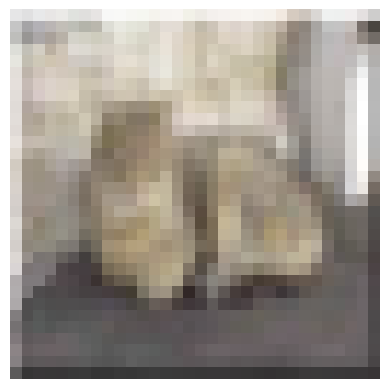

Class: cat
Data_val Len: 10000
Label_val: 2


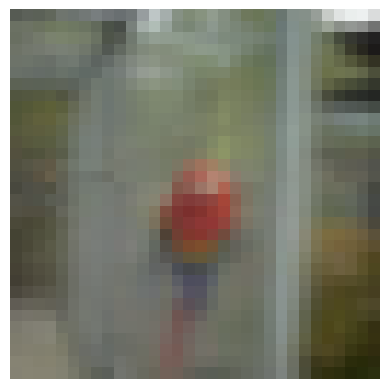

Class_val: bird


In [5]:
import matplotlib.pyplot as plt

index = 2137 

image, label = cifar10[index]
print("Data Len:", len(cifar10))
print("Label:", label)
plt.imshow(image)
plt.axis('off')
plt.show()
print("Class:", class_names[label])


image_val, label_val = cifar10_val[index]
print("Data_val Len:", len(cifar10_val))
print("Label_val:", label_val)
plt.imshow(image_val)
plt.axis('off')
plt.show()
print("Class_val:", class_names[label_val])

### Obrazek jako tensor

Wczytany z użyciem `torchvision` zbiór CIFAR10 zawiera obrazki w postaci obiektów klasy `PIL.Image`. Przed użyciem w treningu modelu należy je przekształcić do postaci tensorów. Różne transformacje obrazów są dostępne w `torchvision.transforms` - będziemy się nimi zajmować mocniej w późniejszym czasie (np. przy okazji zagadnienia "data augmentation"). Dziś wykorzystamy je do konwersji obrazków RGB do tensorów oraz do normalizacji danych.

In [6]:
from torchvision import transforms

In [7]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

#### Ćwiczenie

Do konwersji wybranego obrazka z CIFAR10 z `PIL.Image` do `torch.Tensor` użyj transformacji `transforms.ToTensor()`. Należy najpierw przypisać `transforms.ToTensor()` do zmiennej, np. `to_tensor`, a następnie wywołać `to_tensor(img)` i wynik przypisać do zmiennej, np. `img_t`.

1. Sprawdź zawartość `img_t` oraz wartość `img_t.shape`. Zajrzyj też w "oryginalny" `img` - użyj `list(img.getdata())`.
2. Co się stało z wartościami w `img_t` w porównaniu z `img`? Jak zinterpretować kolejne wymiary tego tensora w `img_t.shape`?

- https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor

In [8]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(image)

print("Zawartość img_t:", img_t)
print("Shape img_t:", img_t.shape)

print("Zawartość oryginalnego obrazka:", list(image.getdata()))

Zawartość img_t: tensor([[[0.9020, 0.8784, 0.9098,  ..., 0.9451, 0.8941, 0.8078],
         [0.7725, 0.6471, 0.7020,  ..., 0.7765, 0.4706, 0.2863],
         [0.7451, 0.5961, 0.6706,  ..., 0.7216, 0.5647, 0.4471],
         ...,
         [0.5490, 0.3961, 0.4118,  ..., 0.4157, 0.4039, 0.3059],
         [0.5255, 0.3529, 0.3647,  ..., 0.3882, 0.3804, 0.2863],
         [0.3569, 0.2118, 0.2235,  ..., 0.2235, 0.2275, 0.2196]],

        [[0.9020, 0.8784, 0.9137,  ..., 0.9333, 0.8784, 0.8039],
         [0.7725, 0.6431, 0.6941,  ..., 0.7490, 0.4353, 0.2706],
         [0.7451, 0.5882, 0.6549,  ..., 0.6824, 0.5294, 0.4235],
         ...,
         [0.5176, 0.3647, 0.3843,  ..., 0.3882, 0.3843, 0.2902],
         [0.5059, 0.3373, 0.3490,  ..., 0.3725, 0.3647, 0.2706],
         [0.3529, 0.2078, 0.2157,  ..., 0.2157, 0.2157, 0.2039]],

        [[0.9059, 0.8824, 0.9176,  ..., 0.9333, 0.8784, 0.8000],
         [0.7725, 0.6510, 0.7137,  ..., 0.7333, 0.4157, 0.2510],
         [0.7333, 0.5804, 0.6549,  ..., 0

#### Ćwiczenie
Transformację `ToTensor()` można podać jako argument `transform` przy tworzeniu zbioru danych jako `Dataset`. Tak utworzony zbiór od razu będzie zawierał PyTorchowe tensory, a nie obrazki `PIL.Image`. 

Stwórz `tensor_cifar10` i `tensor_cifar10_val` zawierające tensory.

In [9]:
tensor_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


#### Ćwiczenie
Uruchom poniższą komórkę, aby zwizualizować tensor `img_t` z użyciem `plt.imshow()`. Funkcja ta oczekuje innej kolejności współrzędnych (H x W x C) niż zawarta w tensorze (C x H x W) - stąd konieczność użycia metody `permute()`.

H - wysokość, W - szerokość, C - kanał (RGB)

ship


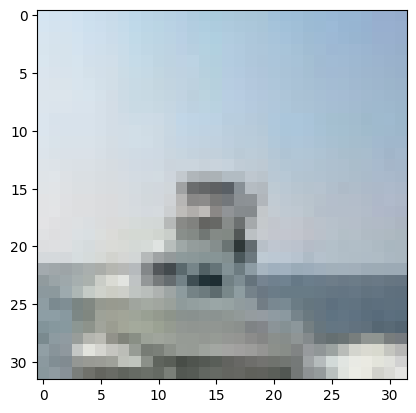

In [10]:
index = 100

img_t, label = tensor_cifar10[index]
plt.imshow(img_t.permute(1, 2, 0))

print(class_names[label])

### Normalizacja danych

Przed użyciem w sieci neuronowej, należy odpowiednio znormalizować dane - normalizacja ułatwia (przyspiesza i stabilizuje) trening modelu. 

Typowym sposobem normalizacji danych obrazkowych jest standaryzacja każdego z dostępnych kanałów - odjęcie policzonej dla niego średniej ze zbioru uczącego i podzielenie przez jego odchylenie standardowe.

#### Ćwiczenie
Uruchom kolejne komórki. Spróbuj wyjaśnić, co się w nich dzieje.

- https://pytorch.org/docs/stable/generated/torch.stack.html (dla przypomnienia)
- https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

In [11]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)

In [12]:
imgs.shape

torch.Size([3, 32, 32, 50000])

In [13]:
per_channel_means = imgs.view(3, -1).mean(dim=1)
per_channel_std = imgs.view(3, -1).std(dim=1)

#### Ćwiczenie

Do normalizacji danych w `torchvision.transforms` słuzy `transforms.Normalize`, której należy podać średnie i odchylenia standardowe dla każdego z kanałów. `transforms.Compose` pozwala natomiast łączyć transformacje w sekwencje - są one aplikowane do danych ładowanych do `Dataset` po kolei.

`transforms.Compose` przyjmuje jako argument listę kolejnych transformacji.

Załaduj zbiór danych do zmiennej `transformed_cifar10`, podając jako argument `transform` złożenie transformacji `ToTensor` i `Normalize`

Sprawdź zawartość dowolnego tensora z `transformed_cifar10`.


- https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize
- https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose


In [16]:
mean = (0, 0, 0)
std = (1, 1, 1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transformed_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
transformed_cifar10_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

sample_image, sample_label = transformed_cifar10[2137]
print("Shape of sample image:", sample_image.shape)
print("Label of sample image:", sample_label)
print("Sample image tensor:", sample_image)

Files already downloaded and verified
Files already downloaded and verified
Shape of sample image: torch.Size([3, 32, 32])
Label of sample image: 3
Sample image tensor: tensor([[[0.9020, 0.8784, 0.9098,  ..., 0.9451, 0.8941, 0.8078],
         [0.7725, 0.6471, 0.7020,  ..., 0.7765, 0.4706, 0.2863],
         [0.7451, 0.5961, 0.6706,  ..., 0.7216, 0.5647, 0.4471],
         ...,
         [0.5490, 0.3961, 0.4118,  ..., 0.4157, 0.4039, 0.3059],
         [0.5255, 0.3529, 0.3647,  ..., 0.3882, 0.3804, 0.2863],
         [0.3569, 0.2118, 0.2235,  ..., 0.2235, 0.2275, 0.2196]],

        [[0.9020, 0.8784, 0.9137,  ..., 0.9333, 0.8784, 0.8039],
         [0.7725, 0.6431, 0.6941,  ..., 0.7490, 0.4353, 0.2706],
         [0.7451, 0.5882, 0.6549,  ..., 0.6824, 0.5294, 0.4235],
         ...,
         [0.5176, 0.3647, 0.3843,  ..., 0.3882, 0.3843, 0.2902],
         [0.5059, 0.3373, 0.3490,  ..., 0.3725, 0.3647, 0.2706],
         [0.3529, 0.2078, 0.2157,  ..., 0.2157, 0.2157, 0.2039]],

        [[0.9059, 0

### Klasyfikacja binarna - ptak czy samolot?

Po przygotowaniu zbioru danych przejdziemy teraz do zadania klasyfikacji binarnej.

Wyobraź sobie, że jesteś leniwym miłośnikiem ptaków, i zamiast wyczekiwać długimi godzinami w lesie, chciałbyś/chciałabyś zautomatyzować proces robienia zdjęć ptakom. Niestety Twój system kamer jest dość wrażliwy i robi zdjęcia często także przelatującym samolotom. Postanawiasz wytrenować sieć neuronową, która wykryje zdjęcia samolotów i usunie je z Twojego systemu.

#### Ćwiczenie

Do opisanego problemu klasyfikacji binarnej możemy wykorzystać podzbiór `CIFAR-10`, wybierając odpowiednio dwie z 10 dostępnych klas. Przypisz im (z wykorzystaniem słownika `label_map`) nowe etykiety - 0 i 1.

Uwaga: 
Stworzone w ten sposób `cifar2` i `cifar2_val` nie będą obiektami klasy `Dataset`, ale na potrzeby dzisiejszych zajęć w zupełności wystarczy nam lista - posiada ona implementacje `__len__` i `__getitem__`.  Wykorzystaj "list comprehension" do przefiltrowania `transformed_cifar10` i `transformed_cifar10_val`.

In [23]:
label_map = {'airplane': 0, 'bird': 1}
new_class_names  = {0: 'airplane', 1: 'bird'}

cifar2 = [(image, label_map[class_names[label]]) for image, label in transformed_cifar10 if class_names[label] in label_map]
cifar2_val = [(image, label_map[class_names[label]]) for image, label in transformed_cifar10_val if class_names[label] in label_map]

Data Len: 10000
Label: 1


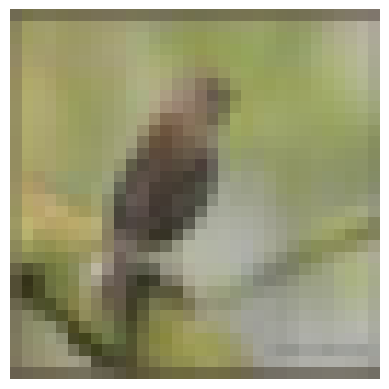

Class: automobile
Data_val Len: 2000
Label_val: 0


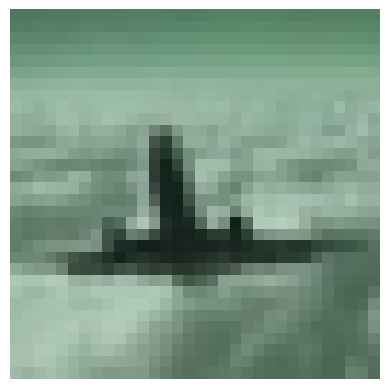

Class_val: airplane


In [26]:
image, label = cifar2[index]
print("Data Len:", len(cifar2))
print("Label:", label)
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()
print("Class:", class_names[label])


image_val, label_val = cifar2_val[index]
print("Data_val Len:", len(cifar2_val))
print("Label_val:", label_val)
plt.imshow(image_val.permute(1, 2, 0))
plt.axis('off')
plt.show()
print("Class_val:", class_names[label_val])

### Gęsta sieć neuronowa

Zbudujemy teraz model sieci neuronowej, wykorzystując poznane poprzednio moduły z `torch.nn`.

Na początek niech sieć składa się kolejno z:
- warstwy liniowej
- funkcji aktywacji
- drugiej warstwy liniowej

Do zbudowania sieci użyj `nn.Sequential` oraz odpowiednich klas reprezentujących warstwy liniowe i wybraną funkcję aktywacji.

#### Ćwiczenie

Zbuduj sieć neuronową, zgodnie z powyższą (i poniższą) instrukcją. Przypisz model do zmiennej `model`.

1. Ile wejść powinna mieć taka sieć? Hint: wymiary / rozmiary tensora.
2. Ile wyjść powinna mieć taka sieć? Czy jedno wystarczy?
3. Niech liczba wyjść z pierwszej i wejść do drugiej warstwy liniowej wynosi 512 (arbitralna wartość).

In [27]:
n_in = 3 * 32 * 32  

n_hidden = 512  

n_out = 1  

model = nn.Sequential(
    nn.Linear(n_in, n_hidden),  
    nn.ReLU(),                  
    nn.Linear(n_hidden, n_out)  
)

### Wyjście z klasyfikatora - softmax

Wyjścia z powyżej zdefiniowanego modelu to tzw. logity - "surowe" wartości liczbowe - tyle wartości, ile wyjść. Im wyższa wartość danego logitu, tym model "bardziej przewiduje" klasę przypisaną do danego wyjścia. 

Typowo w zagadnieniu klasyfikacji logity normalizuje się z użyciem funkcji **softmax** (przy jednym wyjściu "wystarczy" sigmoid). Wartości otrzymane w wyniku normalizacji można interpretować jako prawdopodobieństwa / pewności (ang. confidence scores) modelu co do predykcji klasy obiektu.

#### Ćwiczenie

Sprawdź działanie funkcji softmax zdefiniowanej poniżej oraz zaimplementowanej jako `nn.Softmax` na przykładowym tensorze.

In [28]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [29]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [30]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

#### Ćwiczenie
Rozbuduj poprzednio zbudowany model o `nn.Softmax` podając `dim=1` (dlaczego akurat 1? czym jest dim=0?)

- https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

In [39]:
model_softmax = nn.Sequential(
    nn.Linear(n_in, n_hidden),  # Warstwa liniowa
    nn.ReLU(),                  # Funkcja aktywacji ReLU
    nn.Linear(n_hidden, 2), # Druga warstwa liniowa
    nn.Softmax(dim=1)           # Warstwa Softmax
)

#### Ćwiczenie
Przepuść przez model wybrany przykład ze zbioru `cifar2`. Czy model dobrze rozpoznał klasę? Jeśli tak - czy mamy gotowy model?

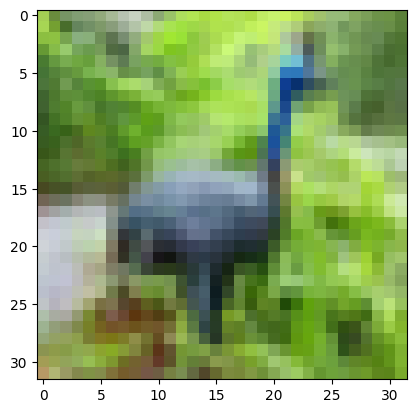

tensor([[0.5660, 0.4340]], grad_fn=<SoftmaxBackward0>)
airplane


In [41]:
new_class_names  = {0: 'airplane', 1: 'bird'}

# wizualizacja obrazka
index = 0

img, _ = cifar2[index]
plt.imshow(img.permute(1, 2, 0))
plt.show()

# "wypłaszczenie" obrazka + dodatkowy wymiar "1" (unsqueeze - patrz poprzednie zajęcia)
img_batch = img.view(-1).unsqueeze(0)

# przepuszczenie przez model
out = model_softmax(img_batch)

# prawdopodobieństwa klas
print(out)
# klasa predykcji
print(new_class_names[torch.argmax(out, dim=1).item()])

### Funkcja straty w klasyfikacji

W przypadku zadania regresji jako funkcji straty używaliśmy błędu średniokwadratowego (MSE, `nn.MSELoss`).

W klasyfikacji zależy nam na tym, aby model nauczył się przypisywać wysokie prawdopodobieństwa prawidłowym klasom.

Funkcja straty typowo stosowana w klasyfikacji nazywa się **entropią krzyżową** (ang. cross-entropy loss, CE) lub **negative log-likelihood** (NLL) - używana nazwa zależy od kontekstu (matematycznego), ale oba pojęcia dotyczą tego samego "wzoru".

W `torch.nn` jest kilka alternatywnych implementacji realizujących tę funkcję straty, np.:
- `nn.NLLLoss` - przyjmuje na wejście zlogarytmowane prawdopodobieństwa klas - wymaga `nn.LogSoftmax` zamiast `nn.Softmax`
- `nn.CrossEntropyLoss` - przyjmuje na wejście logity - model bez softmaxu

czyli: `nn.CrossEntropyLoss` = `nn.LogSoftmax` + `nn.NLLLoss`

różnica: w przypadku `nn.CrossEntropyLoss` wyjścia nie będą znormalizowane - ale często wystarczą nam logity (jako predykcję modelu bierzemy klasę, dla której wartość logitu jest największa).

#### Ćwiczenie

Dla modelu z poprzedniego ćwiczenia oblicz wartość funkcji straty dla wybranego przykładu z `cifar2`. Uruchom komórkę kilka razy - co się dzieje i dlaczego?

In [40]:
model = model_softmax

loss = nn.CrossEntropyLoss()

index = 0
img, label = cifar2[index]
out = model(img.view(-1).unsqueeze(0))
print(out, label)
loss(out, torch.tensor([label]))

tensor([[0.5660, 0.4340]], grad_fn=<SoftmaxBackward0>) 1


tensor(0.7613, grad_fn=<NllLossBackward0>)

### Stochastic Gradient Descent (SGD)

W poprzednich ćwiczeniach zbiór danych był mały (łącznie 11 obserwacji, w tym 9 w zbiorze uczącym) i w każdej iteracji treningu przepuszczaliśmy przez model cały dostępny zbiór. 

W zbiorze `CIFAR` mamy łącznie po 6 tysięcy obrazków dla każdej z klas (5000 w zbiorze uczącym, 1000 w walidacyjnym). Nie będziemy w każdej iteracji treningu przepuszczać przez model całego zbioru danych (nie chodzi tylko o ograniczoną pamięć - model mógłby mieć wtedy problem z nauczeniem się).

Będziemy podawać dane w tzw. "batchach" (liczba przykładów podawanych jednocześnie, czyli batch size, jest hiperparametrem modelu).

Taki wariant algorytmu najszybszego spadku nazywa się:
- SGD - Stochastic Gradient Descent - gdy podajemy jeden przykład w każdej iteracji
- BGD - (Mini-)Batch Gradient Descent - gdy podajemy N przykładów (np. kilka / kilkanaście / kilkadziesiąt) w każdej iteracji

Uwaga:
W praktyce (i w literaturze) nazwa "SGD" używana jest tez w kontekście BGD.

#### Ćwiczenie

Poniższa komórka realizuje algorytm SGD - w każdej iteracji treningu puszczamy przez model jeden obrazek (druga pętla for).

Uruchom poniższą komórkę i obserwuj funkcję straty po każdej epoce treningu.

In [46]:
model = nn.Sequential(
    nn.Linear(3072, 16),
    nn.Tanh(),
    nn.Linear(16, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.922304
Epoch: 1, Loss: 1.089183
Epoch: 2, Loss: 0.913502
Epoch: 3, Loss: 1.467265
Epoch: 4, Loss: 1.122649
Epoch: 5, Loss: 1.801827
Epoch: 6, Loss: 1.501682
Epoch: 7, Loss: 0.915295
Epoch: 8, Loss: 1.954634
Epoch: 9, Loss: 1.139713
Epoch: 10, Loss: 1.072924
Epoch: 11, Loss: 0.981590


KeyboardInterrupt: 

### (Mini-)Batch Gradient Descent

Jak już było wspomniane, zwykle w kolejnych iteracjach treningu podajemy modelowi "trochę" danych - tzw. batch.

Do ładowania kolejnych batchy danych w czasie treningu lub walidacji służy w PyTorchu klasa `DataLoader` z `torch.utils.data`.

Konstruktor tej klasy przyjmuje jako pierwszy argument `Dataset`. Inne interesujące argumenty to `batch_size` oraz `shuffle`.

- https://pytorch.org/docs/stable/data.html

Uwaga:  
Zwykle w każdej epoce treningu "przetasowuje się" zbiór danych. W walidacji kolejność batchy nie ma znaczenia.

#### Ćwiczenie

Stwórz `train_loader` dla zbioru uczącego i `val_loader` dla walidacyjnego, podając `batch_size` równy 64 i pamiętając o przetasowaniu danych (dla zbioru uczącego). 

In [47]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(cifar2, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(cifar2_val, batch_size=batch_size)

#### Ćwiczenie
Zmodyfikuj poprzednią pętlę treningową, aby zrealizować algortym batch gradient descent z wykorzystaniem stworzonego dataloadera.

In [48]:
for epoch in range(n_epochs):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch
        optimizer.zero_grad()
        outputs = model(images.view(images.size(0), -1))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("Epoch {}, Loss: {}".format(epoch+1, total_loss))

Epoch 1, Loss: 79.07141923904419
Epoch 2, Loss: 78.57751631736755
Epoch 3, Loss: 78.82498303055763
Epoch 4, Loss: 78.54070004820824
Epoch 5, Loss: 78.38540798425674
Epoch 6, Loss: 78.56662911176682
Epoch 7, Loss: 78.30540427565575
Epoch 8, Loss: 78.50615027546883
Epoch 9, Loss: 78.19356295466423
Epoch 10, Loss: 78.28715375065804
Epoch 11, Loss: 78.27849996089935
Epoch 12, Loss: 78.24088510870934
Epoch 13, Loss: 78.15006846189499
Epoch 14, Loss: 78.20115804672241
Epoch 15, Loss: 78.1883410513401
Epoch 16, Loss: 78.11526414752007
Epoch 17, Loss: 78.1442574262619
Epoch 18, Loss: 78.14117708802223
Epoch 19, Loss: 77.91086825728416
Epoch 20, Loss: 78.0037449002266
Epoch 21, Loss: 77.81078171730042
Epoch 22, Loss: 78.0015929043293
Epoch 23, Loss: 77.99028071761131
Epoch 24, Loss: 78.08161872625351
Epoch 25, Loss: 78.1432631611824
Epoch 26, Loss: 77.91890335083008
Epoch 27, Loss: 77.87431928515434
Epoch 28, Loss: 77.99519497156143
Epoch 29, Loss: 77.93105393648148
Epoch 30, Loss: 77.724573731

### Walidacja modelu

Na koniec sprawdźmy, jaką dokładność predykcji uzyskamy na zbiorze walidacjnym dla naszej sieci gęstej.

#### Ćwiczenie

1. Uruchom poniższą komórkę, aby sprawdzić dokładność na zbiorze waldiacyjnym.
2. Sprawdź, jaki wynik uzyskasz, podmieniając `val_loader` na `train_loader` w pętli for.
3. Skomentuj uzyskane wyniki.

In [49]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f", correct / total)

Accuracy: %f 0.7805


### Podsumowanie

- poznaliśmy możliwości PyTorcha w zakresie ładowania danych (`Dataset`, `DataLoader`) oraz obróbki danych obrazkowych (`torchvision.transforms`)
- poruszyliśmy takie zagadnienia jak funkcja straty w klasyfikacji (entropia krzyżowa, NLL) czy softmax
- wytrenowaliśmy binarny klasyfikator na podzbiorze zbioru `CIFAR-10` (`torchvision.datasets`) z użyciem algorytmu SGD

Sieci gęste nie sprawdzają się jednak w praktyce w przetwarzaniu obrazów - wkrótce poznamy tzw. sieci splotowe (ang. convolutional neural networks, CNN), które zrewolucjonizowały dziedzinę głębokiego uczenia maszynowego w 2012 roku.